In [1]:
!pip install ncps

# EEG Emotion Detection - NCPS

---


****
**Importing Libraries**

Importing necessary libraries.
****

In [4]:
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt
import keras
from ncps.wirings import AutoNCP
from ncps.tf import LTC
import tensorflow as tf
from ncps import wirings
import tensorflow as tf
from sklearn.utils.class_weight import compute_class_weight
from keras.callbacks import EarlyStopping, ModelCheckpoint

****
**Uploading The Data**

We will be using the dataset "emotions.csv" by Jordan Bird
****

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

In [5]:
data = pd.read_csv('emotions.csv')
len(data)

2132

****
**Viewing the time series data for the row 1, column fft_0_b to fft_749_b**

Since we are certain that the data from column fft_0_a to fft_749_b are time series data, we are going to make use of the data for our machine learning.
****

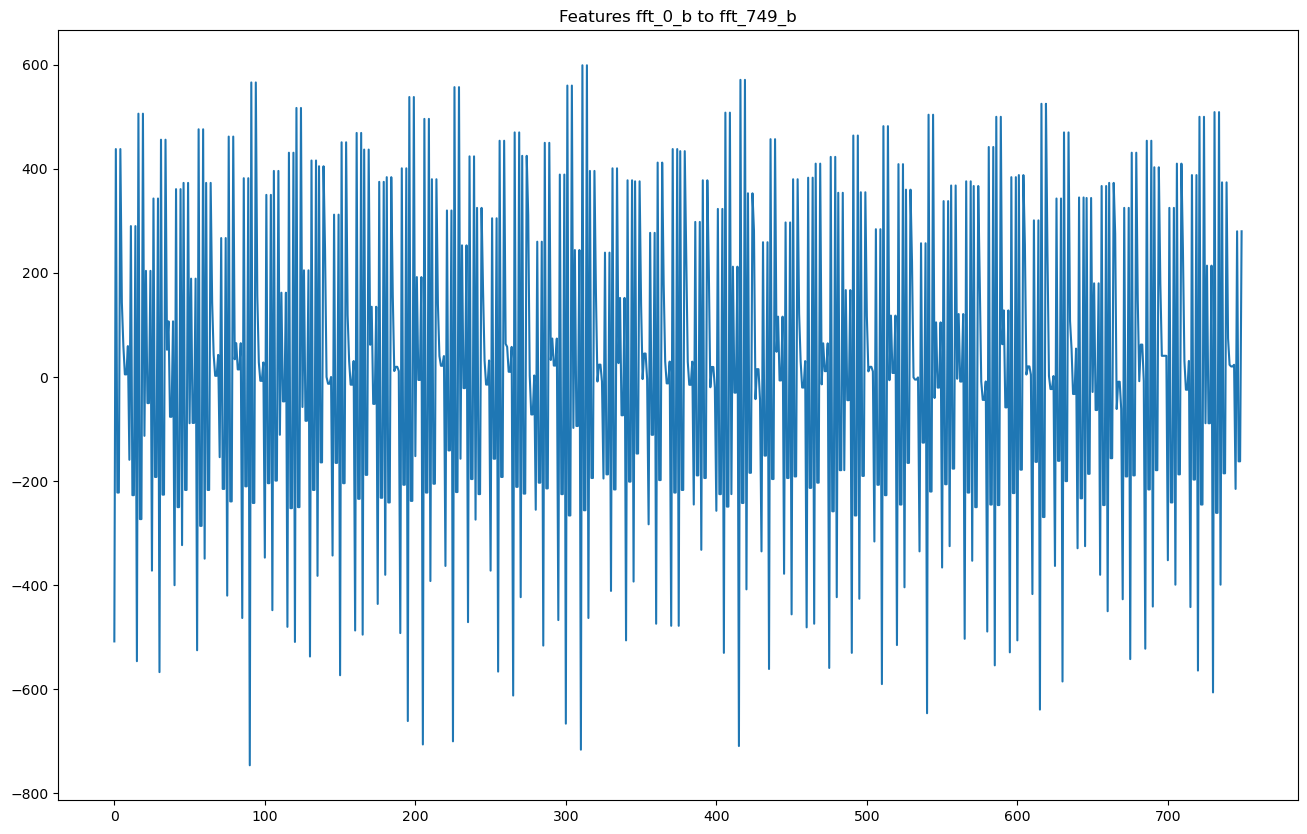

In [6]:
sample = data.loc[0, 'fft_0_b':'fft_749_b']

plt.figure(figsize=(16, 10)) #figure size
plt.plot(range(len(sample)), sample) #range x = length of sample, y = sample
plt.title("Features fft_0_b to fft_749_b")
plt.show()

****
**Counting the total for each label in the column label**

The column named label consists of NEUTRAL, POSITIVE, and NEGATIVE
****

In [7]:
sample = data.iloc[0]
label_mapping = {label: i for i, label in enumerate(data['label'].unique())}

In [8]:
label_mapping
data['label'] = data['label'].map(label_mapping)

In [9]:
data

,# mean_0_a,mean_1_a,mean_2_a,mean_3_a,mean_4_a,mean_d_0_a,mean_d_1_a,mean_d_2_a,mean_d_3_a,mean_d_4_a,...,fft_741_b,fft_742_b,fft_743_b,fft_744_b,fft_745_b,fft_746_b,fft_747_b,fft_748_b,fft_749_b,label
0,4.620,30.3,-356.0,15.60,26.3,1.070,0.411,-15.700,2.060,3.15,...,23.50,20.300,20.300,23.50,-215.0,280.00,-162.00,-162.00,280.00,0
1,28.800,33.1,32.0,25.80,22.8,6.550,1.680,2.880,3.830,-4.82,...,-23.30,-21.800,-21.800,-23.30,182.0,2.57,-31.60,-31.60,2.57,1
2,8.900,29.4,-416.0,16.70,23.7,79.900,3.360,90.200,89.900,2.03,...,462.00,-233.000,-233.000,462.00,-267.0,281.00,-148.00,-148.00,281.00,2
3,14.900,31.6,-143.0,19.80,24.3,-0.584,-0.284,8.820,2.300,-1.97,...,299.00,-243.000,-243.000,299.00,132.0,-12.40,9.53,9.53,-12.40,2
4,28.300,31.3,45.2,27.30,24.5,34.800,-5.790,3.060,41.400,5.52,...,12.00,38.100,38.100,12.00,119.0,-17.60,23.90,23.90,-17.60,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2127,32.400,32.2,32.2,30.80,23.4,1.640,-2.030,0.647,-0.121,-1.10,...,-21.70,0.218,0.218,-21.70,95.2,-19.90,47.20,47.20,-19.90,1
2128,16.300,31.3,-284.0,14.30,23.9,4.200,1.090,4.460,4.720,6.63,...,594.00,-324.000,-324.000,594.00,-35.5,142.00,-59.80,-59.80,142.00,2
2129,-0.547,28.3,-259.0,15.80,26.7,9.080,6.900,12.700,2.030,4.64,...,370.00,-160.000,-160.000,370.00,408.0,-169.00,-10.50,-10.50,-169.00,0
2130,16.800,19.9,-288.0,8.34,26.0,2.460,1.580,-16.000,1.690,4.74,...,124.00,-27.600,-27.600,124.00,-656.0,552.00,-271.00,-271.00,552.00,0


In [10]:
data['label'].value_counts()

label
1    716
0    708
2    708
Name: count, dtype: int64

****
**Checking for null values**

Checking for missing values
****

In [11]:
data.isnull().sum()

# mean_0_a    0
mean_1_a      0
mean_2_a      0
mean_3_a      0
mean_4_a      0
             ..
fft_746_b     0
fft_747_b     0
fft_748_b     0
fft_749_b     0
label         0
Length: 2549, dtype: int64

****
**Labelling the label provided with an integer**

NEGATIVE will be labelled as 0, NEUTRAL as 1, POSITIVE as 2
****

In [12]:
label_mapping = {'NEGATIVE': 0, 'NEUTRAL': 1, 'POSITIVE': 2}
data['label'] = data['label'].replace(label_mapping)

In [13]:
data

,# mean_0_a,mean_1_a,mean_2_a,mean_3_a,mean_4_a,mean_d_0_a,mean_d_1_a,mean_d_2_a,mean_d_3_a,mean_d_4_a,...,fft_741_b,fft_742_b,fft_743_b,fft_744_b,fft_745_b,fft_746_b,fft_747_b,fft_748_b,fft_749_b,label
0,4.620,30.3,-356.0,15.60,26.3,1.070,0.411,-15.700,2.060,3.15,...,23.50,20.300,20.300,23.50,-215.0,280.00,-162.00,-162.00,280.00,0
1,28.800,33.1,32.0,25.80,22.8,6.550,1.680,2.880,3.830,-4.82,...,-23.30,-21.800,-21.800,-23.30,182.0,2.57,-31.60,-31.60,2.57,1
2,8.900,29.4,-416.0,16.70,23.7,79.900,3.360,90.200,89.900,2.03,...,462.00,-233.000,-233.000,462.00,-267.0,281.00,-148.00,-148.00,281.00,2
3,14.900,31.6,-143.0,19.80,24.3,-0.584,-0.284,8.820,2.300,-1.97,...,299.00,-243.000,-243.000,299.00,132.0,-12.40,9.53,9.53,-12.40,2
4,28.300,31.3,45.2,27.30,24.5,34.800,-5.790,3.060,41.400,5.52,...,12.00,38.100,38.100,12.00,119.0,-17.60,23.90,23.90,-17.60,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2127,32.400,32.2,32.2,30.80,23.4,1.640,-2.030,0.647,-0.121,-1.10,...,-21.70,0.218,0.218,-21.70,95.2,-19.90,47.20,47.20,-19.90,1
2128,16.300,31.3,-284.0,14.30,23.9,4.200,1.090,4.460,4.720,6.63,...,594.00,-324.000,-324.000,594.00,-35.5,142.00,-59.80,-59.80,142.00,2
2129,-0.547,28.3,-259.0,15.80,26.7,9.080,6.900,12.700,2.030,4.64,...,370.00,-160.000,-160.000,370.00,408.0,-169.00,-10.50,-10.50,-169.00,0
2130,16.800,19.9,-288.0,8.34,26.0,2.460,1.580,-16.000,1.690,4.74,...,124.00,-27.600,-27.600,124.00,-656.0,552.00,-271.00,-271.00,552.00,0


****
**Defining X and y**

X will contain the original data but without the label column, while y will contain only the label column.
****

In [14]:
X = data.drop('label', axis=1)
y = data['label'].copy()

****
**Preprocessing The Data**

Preprocessing X and y.
****

In [15]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(X)
X = scaler.transform(X)

from tensorflow.keras.utils import to_categorical
y = to_categorical(y)

In [16]:
print (y)
print (type(y))

[[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]
 ...
 [1. 0. 0.]
 [1. 0. 0.]
 [0. 1. 0.]]
<class 'numpy.ndarray'>


****
**Splitting The Data of X and y**

Split arrays or matrices of X and y into random train and test subsets.
****

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = 0.8, random_state = np.random.RandomState)

In [ ]:
X_train.shape

(1705, 2548)

****
**Reshaping X_train and X_test**

Reshaping X_train and X_test without changing its data.
****

In [ ]:
X_train = np.reshape(X_train, (X_train.shape[0],1,X.shape[1]))
X_test = np.reshape(X_test, (X_test.shape[0],1,X.shape[1]))

****
**NCPS Implementation**

Implementing NCPS classification to the data.
****

In [ ]:
X_train.shape

(1705, 1, 2548)

In [ ]:
X_train.shape[2]

2548

In [ ]:
X_test.shape

(427, 1, 2548)

In [ ]:
X_test[0]

array([[-0.02335669,  0.30093361, -3.18598084, ..., -1.77471693,
        -1.77471693,  2.52966724]])

In [ ]:
print(dir(y_train))

['T', '__abs__', '__add__', '__and__', '__array__', '__array_finalize__', '__array_function__', '__array_interface__', '__array_prepare__', '__array_priority__', '__array_struct__', '__array_ufunc__', '__array_wrap__', '__bool__', '__class__', '__class_getitem__', '__complex__', '__contains__', '__copy__', '__deepcopy__', '__delattr__', '__delitem__', '__dir__', '__divmod__', '__dlpack__', '__dlpack_device__', '__doc__', '__eq__', '__float__', '__floordiv__', '__format__', '__ge__', '__getattribute__', '__getitem__', '__gt__', '__hash__', '__iadd__', '__iand__', '__ifloordiv__', '__ilshift__', '__imatmul__', '__imod__', '__imul__', '__index__', '__init__', '__init_subclass__', '__int__', '__invert__', '__ior__', '__ipow__', '__irshift__', '__isub__', '__iter__', '__itruediv__', '__ixor__', '__le__', '__len__', '__lshift__', '__lt__', '__matmul__', '__mod__', '__mul__', '__ne__', '__neg__', '__new__', '__or__', '__pos__', '__pow__', '__radd__', '__rand__', '__rdivmod__', '__reduce__', '

In [ ]:
# X_train = X_train.reshape(X_train.shape[0], 1, X_train.shape[1])
# X_test = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])
import keras
from ncps.wirings import AutoNCP
from ncps.tf import LTC
import tensorflow as tf
from ncps import wirings
import tensorflow as tf
from sklearn.utils.class_weight import compute_class_weight
from keras.callbacks import EarlyStopping, ModelCheckpoint
# import kerasncp as kncp
# from kerasncp.tf import LTCCell
# from ncps import AutoNCP

num_classes = 3
timesteps = 1
input_shape = (timesteps, X_train.shape[2])


# arch = kncp.wirings.Random(32, 1, sparsity_level=0.5)  # 32 units, 1 motor neuron
# rnn_cell = LTCCell(arch)

#wiring = kncp.wirings.FullyConnected(10)
wiring = wirings.AutoNCP(100, 15)
rnn_cell = LTC(wiring)
# cell = MinimalRNNCell(32)

model = keras.models.Sequential(
    [
        keras.layers.InputLayer(input_shape=input_shape),
        keras.layers.Conv1D(filters=82, kernel_size=3, activation='relu', padding='causal'),
        # keras.layers.RNN(rnn_cell, return_sequences=True),
        # LTC(wiring, return_sequences=True),
        # keras.layers.RNN(rnn_cell, return_sequences=False, return_state=False, go_backwards=False, stateful=False, unroll=False),
        LTC(wiring, return_sequences=True),
        keras.layers.GlobalAveragePooling1D(),
        keras.layers.Dense(num_classes, activation="softmax"),
    ]
)


# model.compile(
#     optimizer=keras.optimizers.Adam(0.01),
#     loss='sparse_categorical_crossentropy',
#     metrics=['accuracy'],
#     #run_eagerly=True
# )

model.summary()

model.compile(loss = 'categorical_crossentropy', optimizer = "adam", metrics = ['accuracy'])

# callbacks
early_stopping = EarlyStopping(monitor='val_accuracy', patience=100, verbose=1, mode='max')
model_checkpoint = ModelCheckpoint('test.h5', monitor='val_accuracy', mode='max', verbose=1, save_weights_only=True)

y_train_encoded = to_categorical(y_train)
y_test_encoded = to_categorical(y_test)

# model training
history = model.fit(X_train, y_train, epochs=10, batch_size=30, validation_data=(X_test, y_test), shuffle=True, callbacks=[early_stopping, model_checkpoint])

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_10 (Conv1D)          (None, 1, 82)             626890    
                                                                 
 ltc_21 (LTC)                (None, 1, 15)             73294     
                                                                 
 global_average_pooling1d_10  (None, 15)               0         
  (GlobalAveragePooling1D)                                       
                                                                 
 dense_10 (Dense)            (None, 3)                 48        
                                                                 
Total params: 700,232
Trainable params: 700,232
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
57/57 [==============================] - ETA: 0s - loss: 0.6904 - accuracy: 0.8868
Epoch 1: saving mod

In [ ]:
y_train.shape[1]

3

In [ ]:
yhat = model.predict(X_train[:1, :])
print(yhat)

1/1 [==============================] - 0s 40ms/step
[[0.892562   0.00227506 0.1051629 ]]


In [ ]:
keras.__version__

'2.15.0'

In [ ]:
tf.__version__

'2.15.0'

In [ ]:
model.load_weights("/content/test.h5")

In [ ]:
import os
checkpoint_callback = ModelCheckpoint(os.path.join('models','checkpoint'), monitor='loss', save_weights_only=True)

# ****
**NCPS Summary**

Printing NCPS application summary.
****

****
**Fit Training The Data Using NCPS**

Testing the NCPS.
****

****
**Test Accuracy**

Calculating test accuracy.
****

In [ ]:
from sklearn.metrics import accuracy_score
pred = model.predict(X_test)
predict_classes = np.argmax(pred,axis=1)
expected_classes = np.argmax(y_test,axis=1)

model_acc = accuracy_score(expected_classes,predict_classes)
print("Test Accuracy: {:.3f}%".format(model_acc * 100))

14/14 [==============================] - 1s 21ms/step
Test Accuracy: 93.208%


In [ ]:
X_test


array([[[ 0.95170807,  0.59241686,  0.6758472 , ...,  0.12174612,
          0.12174612, -0.3475551 ]],

       [[ 0.48707989,  0.4412774 ,  0.65936024, ...,  0.68157375,
          0.68157375, -0.67391924]],

       [[ 0.87317936,  0.33332064,  0.64578275, ...,  0.21755555,
          0.21755555, -0.39924173]],

       ...,

       [[ 0.74884224,  0.24695523,  0.61911266, ...,  0.5951574 ,
          0.5951574 , -0.52968893]],

       [[ 0.10752448,  0.45207307,  0.24330694, ...,  0.50009942,
          0.50009942, -1.3640588 ]],

       [[-0.5809105 , -1.01613883,  0.63559962, ...,  0.72384261,
          0.72384261, -0.42331293]]])

In [ ]:
def predictn(row):
  pred1 = model.predict(X_test[row:row+1, :])
  prediction = np.argmax(pred1,axis=1)
  print(pred1)
  print(prediction)

1/1 [==============================] - 0s 141ms/step
[[0.00152122 0.99529207 0.00318679]]
[1]


****
**Confusion Matrix**

Plotting confusion matrix.
****

14/14 [==============================] - 0s 20ms/step
Confusion Matrix:
 [[137   0  22]
 [  0 143   2]
 [  3   2 118]]


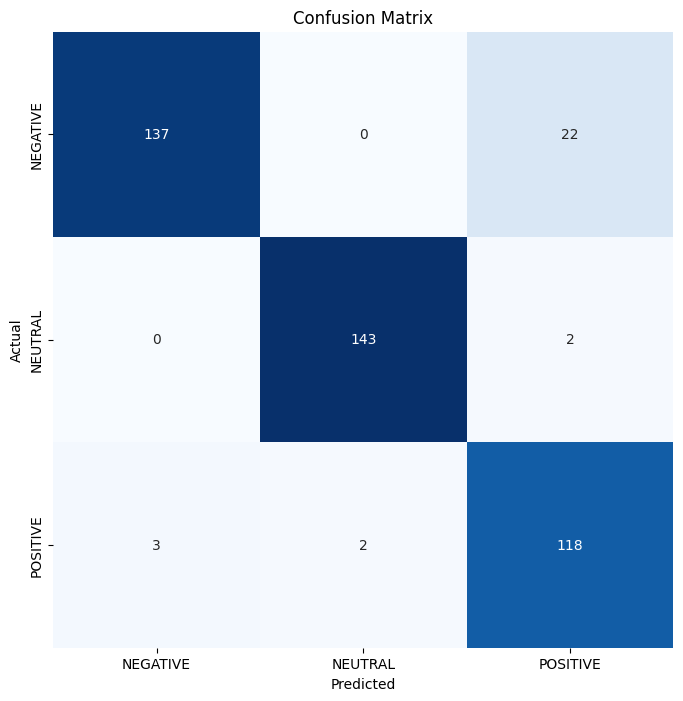

In [ ]:
from sklearn.metrics import confusion_matrix
prediction = model.predict(X_test)
cm = confusion_matrix(prediction.argmax(axis=1),y_test.argmax(axis=1))

print("Confusion Matrix:\n",(cm))

plt.figure(figsize=(8, 8))
sns.heatmap(cm, annot=True, vmin=0, fmt='g', cbar=False, cmap='Blues')
plt.xticks(np.arange(3) + 0.5, label_mapping.keys())
plt.yticks(np.arange(3) + 0.5, label_mapping.keys())
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

****
**Classification Report**

Viewing classification report.
****

In [ ]:
from sklearn.metrics import classification_report
clr = classification_report(prediction.argmax(axis=1), y_test.argmax(axis=1), target_names=label_mapping.keys())

print("Classification Report:\n----------------------\n", clr)

Classification Report:
----------------------
               precision    recall  f1-score   support

    NEGATIVE       0.98      0.86      0.92       159
     NEUTRAL       0.99      0.99      0.99       145
    POSITIVE       0.83      0.96      0.89       123

    accuracy                           0.93       427
   macro avg       0.93      0.94      0.93       427
weighted avg       0.94      0.93      0.93       427



In [ ]:
model.save("NCPS.h5")

In [ ]:
import numpy as np

arr = np.array([[1, 2, 3],
                [4, 5, 6]])

# Find the index of the maximum value in the flattened array
index_flattened = np.argmax(arr)
print("Index of maximum value (flattened):", index_flattened)  # Output: 5

# Find the index of the maximum value along axis 0 (columns)
index_axis_0 = np.argmax(arr, axis=0)
print("Index of maximum value along axis 0:", index_axis_0)  # Output: [1 1 1]

# Find the index of the maximum value along axis 1 (rows)
index_axis_1 = np.argmax(arr, axis=1)
print("Index of maximum value along axis 1:", index_axis_1)  # Output: [2 2]

Index of maximum value (flattened): 5
Index of maximum value along axis 0: [1 1 1]
Index of maximum value along axis 1: [2 2]
